<a href="https://colab.research.google.com/github/ohashi-gnct/exp4e/blob/master/datascience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データサイエンス hands-on

以下の資料のうち、第3章の

- 重回帰分析 multiple regression analysis
- 主成分分析 principal component analysis
- クラスタリング clustering

について、Pythonプログラムを提供します。

https://www.mext.go.jp/a_menu/shotou/zyouhou/detail/mext_00742.html

matplotlibで日本語を使えるようにするための呪文

In [ ]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 3.8MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp37-none-any.whl size=4120276 sha256=665fad5612e8479eaa5ec57df051e077a9f9352f8dd419109867565bc5ec20ac
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
Successfully built japanize-matplotlib


In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import japanize_matplotlib #日本語化matplotlib
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram,linkage

import numpy as np
sns.set(font="IPAexGothic") #日本語フォント設定


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. 重回帰分析

目的変数を、複数の説明変数によって回帰する分析を行う

スポーツテストのデータを読み込み

先頭の5行だけを表示

In [ ]:
df = pd.read_csv('http://www.gifu-nct.ac.jp/elec/ohashi/datascience/sportstest.csv')
df.head()

,校種・学年,性,身長,体重,座高,握力,上体起こし,長座体前屈,反復横跳び,シャトルラン,50ｍ走,立ち幅跳び,ハンドボール投げ
0,1,male,167.6,56.2,89.8,35,33,55,49,112,7.0,235,31
1,1,male,157.1,50.5,85.8,33,29,48,57,70,7.4,205,29
2,1,male,165.4,61.0,85.2,34,31,45,54,76,8.0,237,22
3,1,male,168.0,60.0,91.1,40,31,55,52,76,7.5,225,23
4,1,male,165.9,49.0,89.7,37,32,62,56,87,7.8,240,26


`male`の1年生だけを取り出し

In [ ]:
df2 = df[df['性'] == 'male']
df2 = df2[df2['校種・学年'] == 1]
df2 = df2.drop(['校種・学年', '性'], axis=1)
df2.head()

,身長,体重,座高,握力,上体起こし,長座体前屈,反復横跳び,シャトルラン,50ｍ走,立ち幅跳び,ハンドボール投げ
0,167.6,56.2,89.8,35,33,55,49,112,7.0,235,31
1,157.1,50.5,85.8,33,29,48,57,70,7.4,205,29
2,165.4,61.0,85.2,34,31,45,54,76,8.0,237,22
3,168.0,60.0,91.1,40,31,55,52,76,7.5,225,23
4,165.9,49.0,89.7,37,32,62,56,87,7.8,240,26


まずは全ての組み合わせで2次元プロットしてみる

データの分布やデータ間の相関などが直感的にわかる

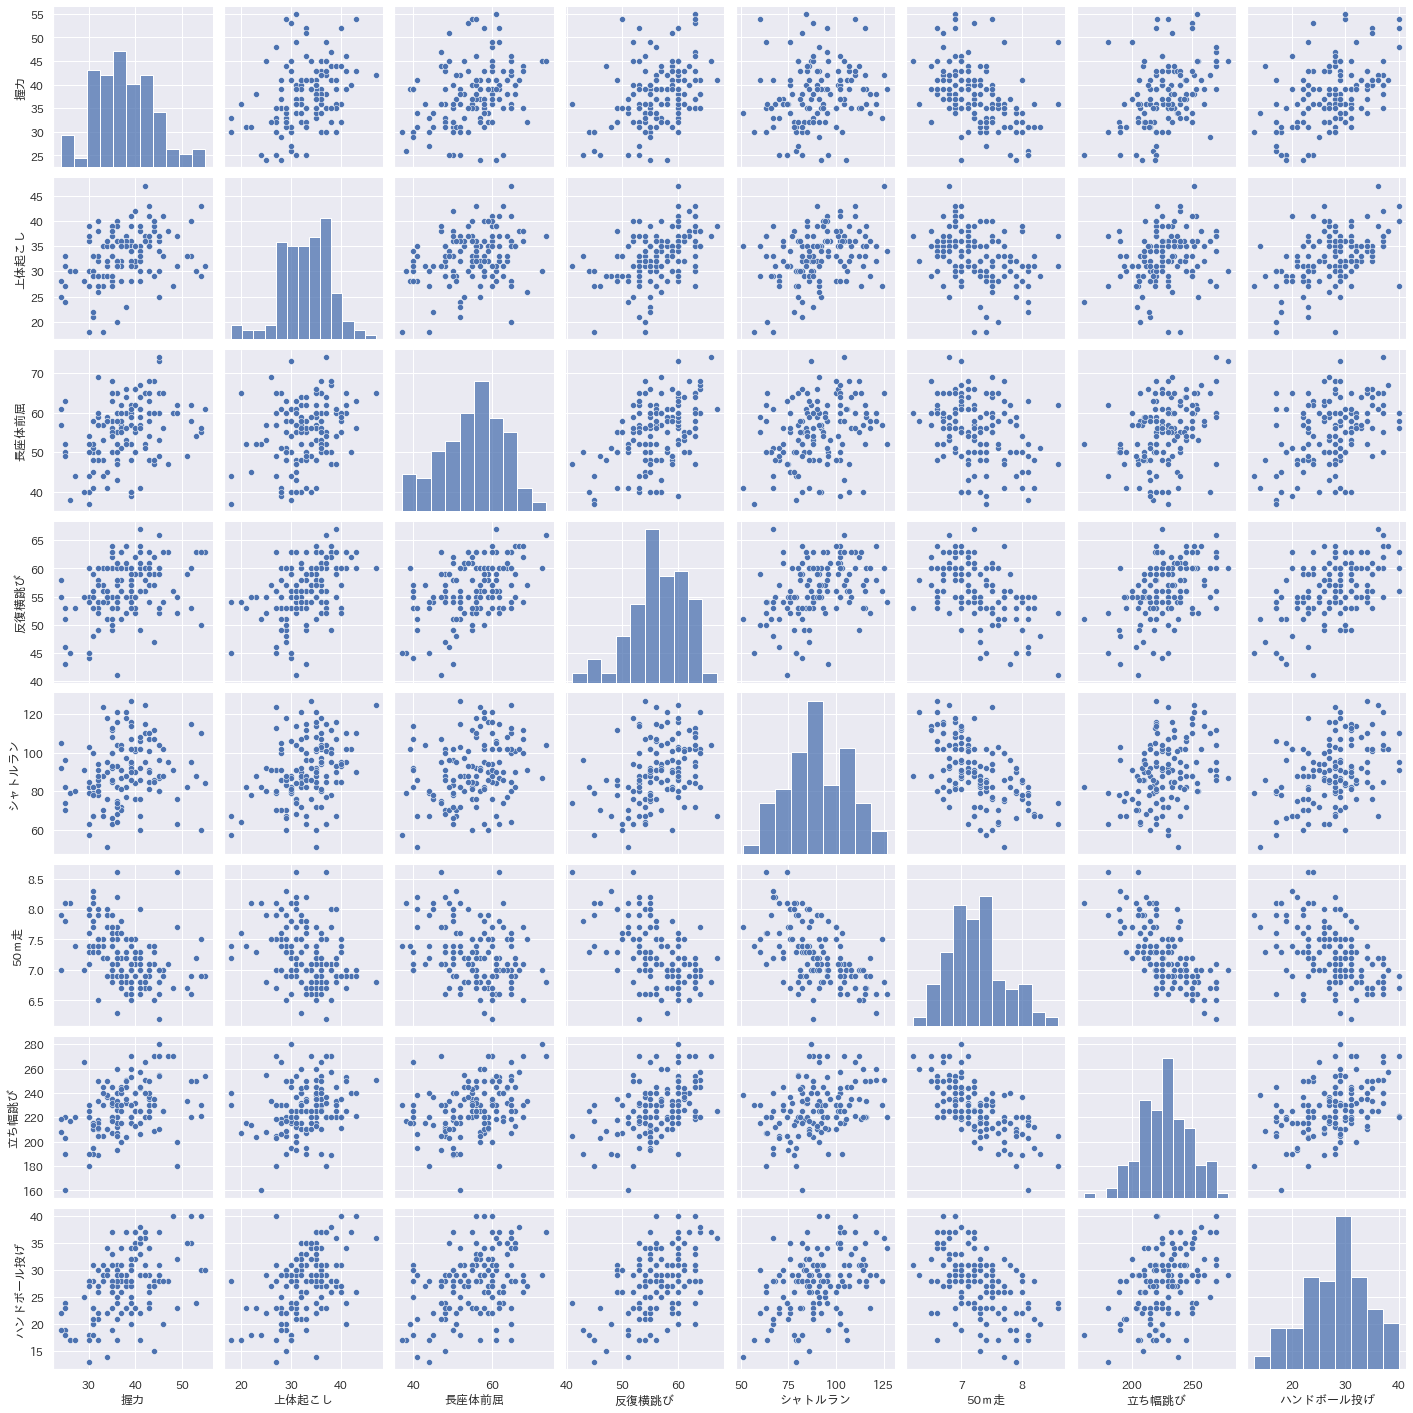

In [ ]:
df_test = df2.drop(['身長', '体重', '座高'], axis=1)
sns.pairplot(df_test)

相関をヒートマップとして出してみる

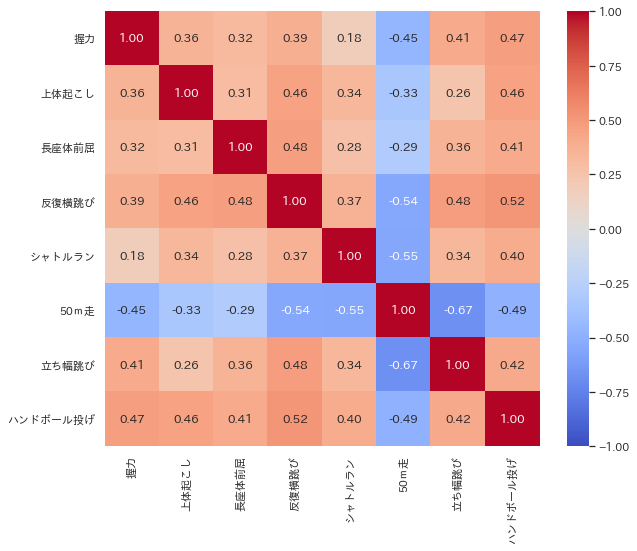

In [ ]:
corr = df_test.corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, vmax=1, vmin=-1, center=0, annot=True, cbar=True, 
            cmap='coolwarm', square=True, fmt='.2f', ax=ax)


まずは、単回帰分析を行う

50m走を目的変数、立ち幅跳びを説明変数として線形回帰してみる

決定係数 $ R^2 $ とは、目的変数 $ Y $ の変動の何パーセントが

与えられた回帰モデルで説明できるかを示す指標。

100%に近いほど、モデルがデータに適合している。

No handles with labels found to put in legend.


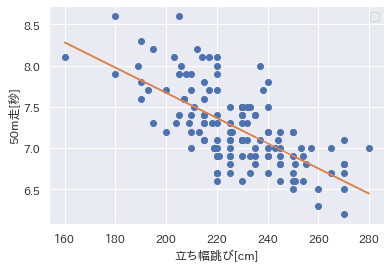

y= -0.015x + 10.731
決定係数 R^2：  0.454565211472451


In [ ]:
# https://qiita.com/karaage0703/items/701367b6c926552fe505

x = df2[['立ち幅跳び']]
y = df2[['50ｍ走']]

model_lr = LinearRegression()
model_lr.fit(x, y)

plt.plot(x, y, 'o')
plt.plot(x, model_lr.predict(x), linestyle="solid")
plt.xlabel('立ち幅跳び[cm]')
plt.ylabel('50m走[秒]')
plt.legend()
plt.show()

print('y= %.3fx + %.3f' % (model_lr.coef_ , model_lr.intercept_))
print('決定係数 R^2： ', model_lr.score(x, y))

次に、重回帰分析を行う。

In [ ]:
df2.head()

,身長,体重,座高,握力,上体起こし,長座体前屈,反復横跳び,シャトルラン,50ｍ走,立ち幅跳び,ハンドボール投げ
0,167.6,56.2,89.8,35,33,55,49,112,7.0,235,31
1,157.1,50.5,85.8,33,29,48,57,70,7.4,205,29
2,165.4,61.0,85.2,34,31,45,54,76,8.0,237,22
3,168.0,60.0,91.1,40,31,55,52,76,7.5,225,23
4,165.9,49.0,89.7,37,32,62,56,87,7.8,240,26


50m走を目的変数、それ以外のテストを説明変数とし、

重回帰分析を行う。

In [ ]:
# https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html

X = df2.drop(['50ｍ走', '身長', '体重', '座高'], axis=1)
Y = df2['50ｍ走']
est = sm.OLS(Y, X)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                   50ｍ走   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                              1182.
Date:                Thu, 06 May 2021   Prob (F-statistic):                   1.04e-113
Time:                        01:14:56   Log-Likelihood:                         -178.61
No. Observations:                 136   AIC:                                      371.2
Df Residuals:                     129   BIC:                                      391.6
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<table id="tablepress-60" class="tablepress tablepress-id-60">
<thead>
<tr class="row-1 odd">
	<th class="column-1">名称</th><th class="column-2">意味</th>
</tr>
</thead>
<tbody class="row-hover">
<tr class="row-2 even">
	<td class="column-1">R-squared</td><td class="column-2">決定係数。これが1に近いほど精度の高い分析と言える。</td>
</tr>
<tr class="row-3 odd">
	<td class="column-1">Adj. R-squared</td><td class="column-2">自由度調整済み決定係数。説明変数が多い時は決定係数の代わりに用いる。</td>
</tr>
<tr class="row-4 even">
	<td class="column-1">AIC</td><td class="column-2">モデルの当てはまり度を示す。小さいほど精度が高い。相対的な値である。</td>
</tr>
<tr class="row-5 odd">
	<td class="column-1">coef</td><td class="column-2">回帰係数</td>
</tr>
<tr class="row-6 even">
	<td class="column-1">std err</td><td class="column-2">二乗誤差</td>
</tr>
<tr class="row-7 odd">
	<td class="column-1">t</td><td class="column-2">t値。</td>
</tr>
<tr class="row-8 even">
	<td class="column-1">p</td><td class="column-2">p値。有意水準以下の値を取れば、回帰係数の有意性が言える。</td>
</tr>
<tr class="row-9 odd">
	<td class="column-1">[0.025      0.975]</td><td class="column-2">95%信頼区間。</td>
</tr>
</tbody>
</table>




https://ai-trend.jp/programming/python/linearregression/

より

`R-squared`（決定係数 $ R^2 $ ）と、

`Adj.R-squared`（自由度修正済み $ R^2 $ ）をチェック

とうぜん説明変数を増やせばデータへの当てはまりはよくなるが、

データの特徴を適切にとらえられているか？考える必要がある

では、

説明変数を反復横飛び、握力、シャトルランの3つだけにして重回帰分析してみる

In [ ]:
X = df2.loc[:, ['反復横跳び', '握力', 'シャトルラン']]
Y = df2['50ｍ走']
est = sm.OLS(Y, X)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                   50ｍ走   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                              2379.
Date:                Thu, 06 May 2021   Prob (F-statistic):                   2.52e-115
Time:                        01:15:08   Log-Likelihood:                         -190.54
No. Observations:                 136   AIC:                                      387.1
Df Residuals:                     133   BIC:                                      395.8
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

さきほどより決定係数は小さくなったが、

データの解釈はしやすくなった

## 2. 主成分分析

多変量データのうち、複数の変数をまとめて主成分（新たな特徴量）をつくり、

その解釈を行う。


https://www.intage.co.jp/glossary/401/
より

さきほどと同じ、標準化したデータを使う

In [ ]:
display(df_normalized)

,身長,体重,座高,握力,上体起こし,長座体前屈,反復横跳び,シャトルラン,50ｍ走,立ち幅跳び,ハンドボール投げ
0,-0.001860,-0.086154,-0.031778,-0.428292,0.004388,-0.026194,-1.464944,1.346314,-0.516245,0.348070,0.588606
1,-1.899505,-0.805834,-1.284482,-0.736481,-0.791386,-0.916780,0.128915,-1.265828,0.319580,-1.074902,0.247966
2,-0.399462,0.519893,-1.472387,-0.582386,-0.393499,-1.298459,-0.468782,-0.892665,1.573318,0.442935,-0.944275
3,0.070431,0.393633,0.375350,0.342180,-0.393499,-0.026194,-0.867247,-0.892665,0.528536,-0.126254,-0.773955
4,-0.309098,-0.995223,-0.063096,-0.120103,-0.194555,0.864392,-0.070317,-0.208532,1.155405,0.585232,-0.262994
...,...,...,...,...,...,...,...,...,...,...,...
131,1.172872,1.340581,0.437986,-1.044670,0.004388,-1.807365,-0.668014,-1.452410,1.991230,-1.549226,-1.114595
132,0.251159,0.014854,-0.125731,-0.428292,0.999107,1.627751,1.523541,0.599988,0.946449,-0.363416,-0.262994
133,2.166876,0.898672,1.158290,-0.428292,-0.791386,0.991619,-0.668014,-0.270726,0.946449,-0.505713,-0.092674
134,0.431887,-0.742704,-0.031778,-0.890575,1.396995,0.482712,-0.867247,0.226825,0.528536,-0.790308,-0.262994


主成分分析を行う

`PC1`, `PC2`…というのが主成分

主成分負荷量（主成分と元の変数との相関係数）を出してみる

In [ ]:
# https://qiita.com/maskot1977/items/082557fcda78c4cdb41f
df_test = df_normalized.drop(['身長', '体重', '座高'], axis=1)
pca = PCA()
pca.fit(df_test)
feature = pca.transform(df_test)

index_pc = ["PC{}".format(x + 1) for x in range(len(df_test.columns))]

In [ ]:
df_pc = pd.DataFrame(pca.components_, columns=df_test.columns, index=index_pc)
display(df_pc)

,握力,上体起こし,長座体前屈,反復横跳び,シャトルラン,50ｍ走,立ち幅跳び,ハンドボール投げ
PC1,-0.325202,-0.314119,-0.307786,-0.393395,-0.313262,0.405718,-0.368104,-0.384500
PC2,0.268218,0.435167,0.374578,0.120362,-0.444422,0.462051,-0.366939,0.195568
PC3,0.532974,-0.422258,-0.015031,-0.051835,-0.597602,-0.117292,0.400185,-0.060750
PC4,-0.399934,-0.408344,0.759876,0.204047,-0.017037,0.106365,0.139333,-0.152460
PC5,-0.365366,0.403225,-0.241145,0.496749,-0.390053,-0.070993,0.305585,-0.385284
PC6,0.314417,0.333213,0.287767,-0.356385,0.217597,-0.042159,0.100496,-0.721849
PC7,0.342095,-0.294312,-0.102389,0.611981,0.175419,-0.085980,-0.505946,-0.342347
PC8,0.170043,-0.081685,-0.189412,0.195297,0.341579,0.763296,0.436842,-0.016367


ちょっと分かりにくいので、ヒートマップにする

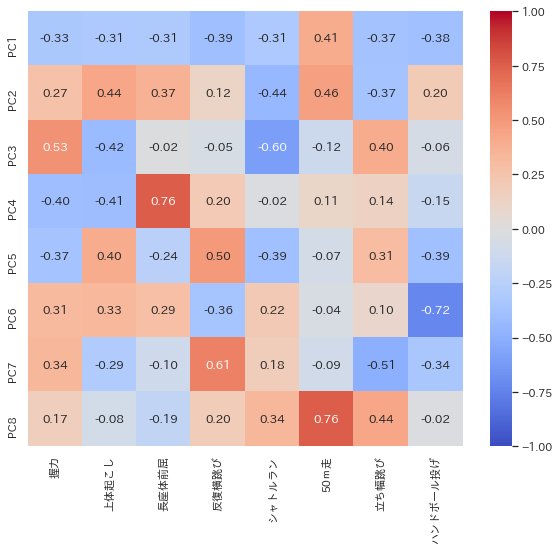

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_pc, vmax=1, vmin=-1, center=0, annot=True, cbar=True, 
            cmap='coolwarm', square=True, fmt='.2f', ax=ax)

固有値を求める

固有値：各種成分が含んでいる情報の大きさのようなもの

In [ ]:
pd.DataFrame(pca.explained_variance_, index=index_pc, columns=['固有値'])

,固有値
PC1,3.872025
PC2,0.907182
PC3,0.827447
PC4,0.731672
PC5,0.536861
PC6,0.470270
PC7,0.409563
PC8,0.244979


それぞれの主成分の寄与率を求める。

寄与率：その主成分によって元データの分散がどの程度説明できるかを示す

累積寄与率：`PC1`, `PC2`... と続く主成分の各寄与率の合計

`PC3`までで、90%の分散が説明できることがわかる

分散を残しつつ、次元を圧縮することができた

In [ ]:
contribution = list(pca.explained_variance_ratio_)
cum_contribution = list(np.cumsum(pca.explained_variance_ratio_))
print(contribution)
print(cum_contribution)
pd.DataFrame(zip(contribution, cum_contribution), index=index_pc,
             columns=['寄与率', '累積寄与率'])

[0.48400314495279934, 0.11339777357596609, 0.10343084997505887, 0.09145905537736063, 0.06710768521381068, 0.05878371166344089, 0.05119542631326001, 0.030622352928303554]
[0.48400314495279934, 0.5974009185287654, 0.7008317685038243, 0.792290823881185, 0.8593985090949957, 0.9181822207584366, 0.9693776470716966, 1.0000000000000002]


,寄与率,累積寄与率
PC1,0.484003,0.484003
PC2,0.113398,0.597401
PC3,0.103431,0.700832
PC4,0.091459,0.792291
PC5,0.067108,0.859399
PC6,0.058784,0.918182
PC7,0.051195,0.969378
PC8,0.030622,1.000000


いくつの主成分を採用すべきかは図を描いて考える

累積寄与率が飽和し始めるくらいがよい

もしくは80%くらい

今回だと2か3くらい

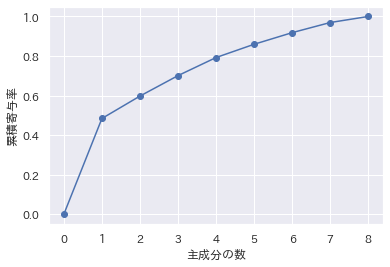

In [ ]:
plt.plot([0] + cum_contribution, '-o')
plt.xlabel('主成分の数')
plt.ylabel('累積寄与率')
plt.show()

`PC1`と`PC2`での観測変数の寄与度をプロット

それぞれの主成分は何を考慮した値なのかが分かる

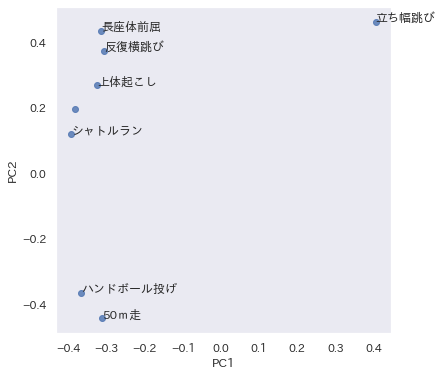

In [ ]:
plt.figure(figsize=(6, 6))
for x, y, name in zip(pca.components_[0], pca.components_[1], df_test.columns[1:]):
    plt.text(x, y, name)
plt.scatter(pca.components_[0], pca.components_[1], alpha=0.8)
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

これと主成分負荷量のヒートマップを見る。

これらを解釈し、

「**この主成分にはどんな意味付けができるか？**」

「**この主成分は、どんな能力を示しているといえるか？**」

考えることが非常に重要

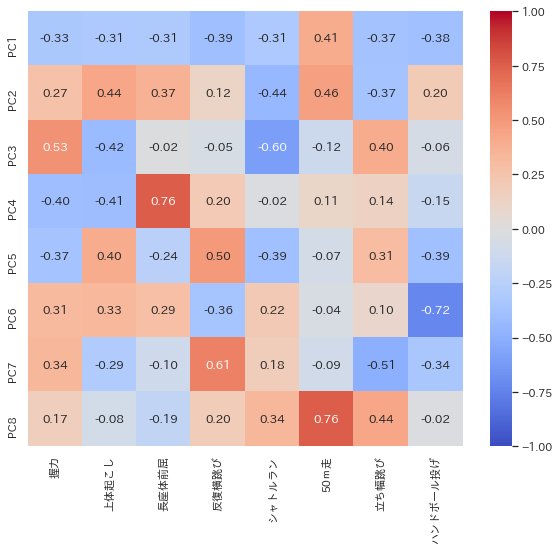

## 3. クラスタリング

多次元データを、距離を基準にグループ化する

クラスタリングについて学習する

今回は、e-Statの家計消費状況調査を使う

まずはデータを読み込む

In [ ]:
df = pd.read_csv('http://www.gifu-nct.ac.jp/elec/ohashi/datascience/household_economy.csv', index_col=0)
display(df)

,通信費用,旅行費用,教育費用,衣料費用,医療費用,家具費用,家電等費用,自動車費用,冠婚葬祭費用,仕送り金
全国,19103,1258,11045,1951,1989,1512,5064,28093,3661,2321
北海道,17531,1954,4193,1992,748,1637,3342,26469,799,2187
東北,18688,1317,8632,1681,1652,781,4790,30851,7055,3135
関東,19653,1398,13732,1757,2116,1802,5276,26122,4016,2006
北陸,19587,2145,4998,1158,1685,1845,3190,37143,2937,3874
東海,19351,1014,10486,2273,1364,1483,6466,38175,3812,2640
近畿,18340,1365,12227,2068,2005,1380,5176,17166,3734,1793
中国,19367,683,7728,2816,2902,1391,5210,37566,2517,2777
四国,19350,478,11994,3818,2866,980,5049,45617,1633,3140
九州・沖縄,18588,782,8575,1562,2295,1240,4075,26034,2625,2350


標準化する

In [ ]:
df_normalized = (df - df.mean()) / df.std()
display(df_normalized)

,通信費用,旅行費用,教育費用,衣料費用,医療費用,家具費用,家電等費用,自動車費用,冠婚葬祭費用,仕送り金
全国,0.220715,0.035099,0.538809,-0.210134,0.041017,0.317445,0.305793,-0.391200,0.227343,-0.480156
北海道,-2.136375,1.348491,-1.653543,-0.155118,-1.858318,0.688639,-1.448289,-0.587854,-1.475497,-0.693701
東北,-0.401545,0.146436,-0.233249,-0.572433,-0.474757,-1.853297,0.026688,-0.057228,2.246714,0.817047
関東,1.045396,0.299287,1.398537,-0.470453,0.235389,1.178615,0.521743,-0.629873,0.438562,-0.982145
北陸,0.946435,1.708918,-1.395977,-1.274221,-0.424251,1.306305,-1.603121,0.704683,-0.203425,1.994728
東海,0.592571,-0.425343,0.359953,0.221942,-0.915537,0.231328,1.733913,0.829650,0.317185,0.028207
近畿,-0.923343,0.237014,0.917000,-0.053137,0.065505,-0.074536,0.419880,-1.714374,0.270777,-1.321585
中国,0.616562,-1.049958,-0.522491,0.950567,1.438352,-0.041871,0.454513,0.755905,-0.453317,0.246532
四国,0.591072,-1.436805,0.842449,2.295101,1.383254,-1.262356,0.290514,1.730818,-0.979282,0.825015
九州・沖縄,-0.551487,-0.863140,-0.251487,-0.732114,0.509346,-0.490273,-0.701633,-0.640529,-0.389059,-0.433941


クラスタリングを行い、デンドログラムを描く

早い段階で結合しているほど、その2つは近い位置にある

これをどこかで縦に切ることで、クラスタリングできる

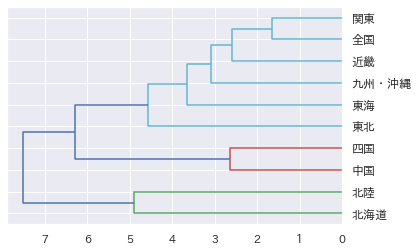

In [ ]:
z = linkage(df_normalized, method='ward', metric='euclidean')
den = dendrogram(z, labels=df.index, orientation='left',
                 distance_sort='des')

次に、卸売業者のデータをk-meansによってクラスタリングする

In [ ]:
df = pd.read_csv("http://www.gifu-nct.ac.jp/elec/ohashi/datascience/Wholesale_customers_data.csv")
sub_cols=df[['Fresh','Milk', 'Grocery','Frozen', 'Detergents_Paper','Delicassen']]
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


クラスタ数とSSE（クラスタ内誤差の平方和）をプロットすることで、

適切なクラスタ数を考える助けになる

今回は4～6くらいがよさそう

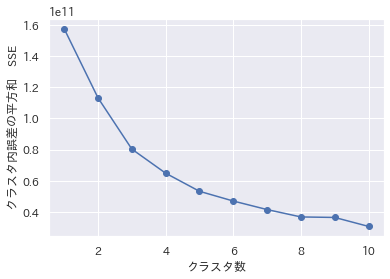

In [ ]:
dist_list=[]
for i in range( 1, 11 ):
    kmeans = KMeans(init='random', n_clusters=i,random_state=0)
    y_km = kmeans.fit(sub_cols)
    dist_list.append(kmeans.inertia_)

plt.plot(range(1,11),dist_list,marker='o')
plt.xlabel('クラスタ数')
plt.ylabel('クラスタ内誤差の平方和　SSE')
plt.show()

k-meansによってクラスタリングする

クラスタリングしたデータの特徴を、属性ごとに平均値をとって調べる

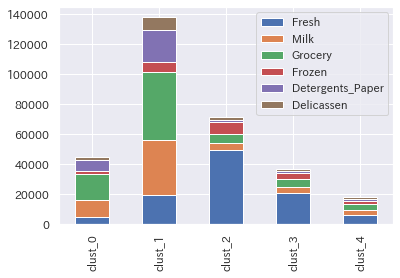

In [ ]:
# n_clustersがクラスタ数
kmeans = KMeans(init='random', n_clusters=5, random_state=0)
pred = kmeans.fit_predict( sub_cols )
df['cluster_id'] = pred

clusterinfo = pd.DataFrame()
for i in range(5):
    clusterinfo['clust_' + str(i)] = df[df['cluster_id'] == i].mean()
clusterinfo = clusterinfo.drop(['Channel','Region','cluster_id'])
clusterinfo.T.plot.bar(stacked=True)

各クラスタに含まれるデータ数を調べる

Text(0, 0.5, 'データ数')

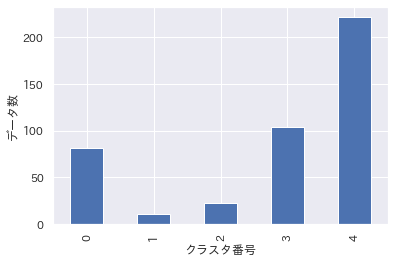

In [ ]:
labels = pd.Series(kmeans.labels_,name='cluster_number')
ax=labels.value_counts(sort=False).plot(kind='bar')
ax.set_xlabel('クラスタ番号')
ax.set_ylabel('データ数')